In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [2]:
# %matplotlib inline
from matplotlib import pyplot as plt
import re
import seaborn as sns
import RNA
import numpy as np
import matplotlib
import pandas as pd
from Bio import SeqIO
import random
import os
plt.rcParams["axes.grid"] = True
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally

In [3]:
def my_heatmap(mat, fig, ax, title='', vmin=1e-2,vmax=1.0, inverse=True, interactive=False, gene_loc=None,colormap='hot'):

    seq_len = mat.shape[0]

    if interactive is True:
        print ("Interactive, large memory consumer!")
#         plugins.clear(ax)
#         plugins.connect(fig, plugins.Reset(), plugins.BoxZoom(), plugins.Zoom())
        ax.plot(np.arange(seq_len+1, -1), np.arange(seq_len+1, -1),  c='black')
    else:
        ax.plot(np.arange(-1, seq_len+1), np.arange(-1, seq_len+1), c='black')
        if gene_loc is not None:
            print (gene_loc)
            assert len(gene_loc) == 2
            # gene_loc = gene_loc[0]+0.5 + gene_loc[1]+0.5
            ax.plot(np.arange(gene_loc[0]-1, gene_loc[1]), np.arange(gene_loc[0]-1, gene_loc[1]), c='green', linewidth=2)
            ax.plot(np.ones(gene_loc[1]-gene_loc[0]+1)*(gene_loc[1]-1), np.arange(gene_loc[0]-1, gene_loc[1]), c='green', linewidth=1)
            ax.plot(np.arange(gene_loc[0]-1, gene_loc[1]), np.ones(gene_loc[1]-gene_loc[0]+1)*(gene_loc[0]-1),  c='green', linewidth=1)

    if inverse:
        cmap = plt.get_cmap(colormap+'_r')
        if colormap == 'hot':
            cmap = truncate_colormap(cmap, 0.3, 1.1)  # Discards super white range of hit map
    else:
        cmap = plt.get_cmap(colormap)
        if colormap == 'hot':
            cmap = truncate_colormap(cmap, 0.35, 1.0)  # Discards super white range of hit map

#     plugins.connect(fig, plugins.MousePosition(fontsize=14))

    heatmap = ax.matshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, ) #, interpolation='nearest')
#     y, x = np.mgrid[:mat.shape[0], :mat.shape[1]]
#     x,y = x.ravel(),y.ravel()

#     scatter = ax.scatter(x, y, c=mat, s=40, marker='s', edgecolor='none')
#     fig.plugins = [plugins.PointLabelTooltip(scatter, None)]

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if colormap == 'hot':
        barticks = [vmin] + [r/10.0 for r in range(1, 11)]
        barlabels = [str(vmin)] + [str(r/10.0) for r in range(1, 11)]
    
        cbar = fig.colorbar(heatmap, extend='min', ticks=barticks ,fraction=0.043, pad=0.04)
    else:
        barticks =  [r/10.0 for r in range(-10, 11)]
        barlabels = [str(r/10.0) for r in range(-10, 11)]
        cbar = fig.colorbar(heatmap,  ticks=barticks ,fraction=0.043, pad=0.04)

    # cbar.ax.set_yticklabels(barlabels)
    if inverse:
        cbar.cmap.set_under('white')
    else:
        cbar.cmap.set_under('black')

    #     plt.colorbar(heatmap)

    ax.set_title(title)
    ticks = np.arange(0, mat.shape[0], 10)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticks(ticks-0.5, minor=True)
    ax.set_yticks(ticks-0.5, minor=True)
#     ax.grid(True, which='minor',color='gray',linewidth=0.0001 )
    ax.grid(False, which='major')  # ,color='gray',linewidth=0.001 )
    #     ax.gca().patch.set_facecolor('0.8')
    ax.tick_params(length=0,
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

    ax.set_xlim((-0.5, seq_len-0.5))
#     ax.set_ylim((-0.5,seq_len-0.5))
    ax.set_ylim((seq_len-0.5, -0.5))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

    
def plot_heat_maps(mfe_probs, bp_probs_whole, filename='', what='basepairs', inverse=True, 
                   interactive=False, gene_loc=None, title_suffix='',vmin=1e-2,vmax=1.0, out_dir='./',
                   upper_triangle_txt='',lower_triangle_txt='',colormap='hot'):
    if what == 'all':
        fig = plt.figure(figsize=(20, 5))
        subplot_num = 140
    else:
        fig = plt.figure(figsize=(7, 7))
        subplot_num = 110

    if what == 'basepairs' or what == 'all':
        my_heatmap(bp_probs_whole, fig, fig.add_subplot(subplot_num + 1), title_suffix
                   , inverse=inverse, interactive=interactive, gene_loc=gene_loc,vmin=vmin,vmax=vmax,colormap=colormap)

    if what == 'mfe-probs' or what == 'all':
        my_heatmap(mfe_probs, fig, fig.add_subplot(subplot_num + 3), 'mfe-probs:'+title_suffix,
                   inverse=inverse, interactive=interactive, gene_loc=gene_loc,vmin=vmin,vmax=vmax,colormap=colormap)
    if what == 'all':
        my_heatmap(bp_probs_whole*mfe_probs, fig, fig.add_subplot(subplot_num + 2), 'bp*struct:'+title_suffix,
                   inverse=inverse, interactive=interactive, gene_loc=gene_loc,vmin=vmin,vmax=vmax,colormap=colormap)
        my_heatmap(np.sqrt(bp_probs_whole*mfe_probs), fig, fig.add_subplot(subplot_num + 4), 'sqrt(bp*struct):'+title_suffix,
                   inverse=inverse, interactive=interactive, gene_loc=gene_loc,vmin=vmin,vmax=vmax,colormap=colormap)


    fig.text(x=0.72,y=0.3,s=upper_triangle_txt, alpha=0.5)
    fig.text(x=0.65,y=0.18,s=lower_triangle_txt, alpha=0.5)
    
    #     fig.savefig(filename+'.png', dpi=800)
    # if inverse:
        # filename += '_inverse'
    #fig.savefig(filename+'.pdf', dpi=300)

    
    fig.savefig(os.path.join(out_dir, filename+'-dotplot.svg'), dpi=300, format="svg")
    fig.savefig(os.path.join(out_dir, filename+'-dotplot.png'), dpi=600, format="png")
    return fig

def getBPPM(sequence, structure="", bppm_cutoff = 0.01):
    #print("\""+sequence+"\"")
    seq_len = len(sequence)

    bppm = np.zeros((seq_len, seq_len))

    RNA.pf_fold(sequence, structure)
    for l_pos in range(0, seq_len):
        for r_pos in range(l_pos, seq_len+1):
            if l_pos<r_pos:
                bpp = RNA.get_pr(l_pos+1, r_pos+1)
                if bpp > bppm_cutoff:
                    bppm[l_pos, r_pos] = bpp
    RNA.free_pf_arrays()
    # print bppm
    return bppm

def getBPPM_plfold(sequence,W=150, L=100, bppm_cutoff = 0.01):
    #print("\""+sequence+"\"")
    seq_len = len(sequence)

    bppm = np.zeros((seq_len, seq_len))

    plfold_probs = RNA.pfl_fold(sequence, w=W, L=L, cutoff=bppm_cutoff)
    for bpp in plfold_probs:
        bppm[bpp.i-1, bpp.j-1] = bpp.p # vienna returns one-based index
    RNA.free_pf_arrays()
    # print bppm
    return bppm


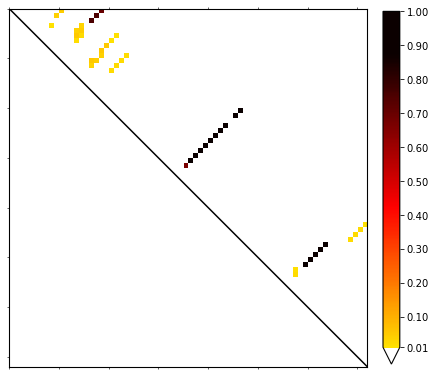

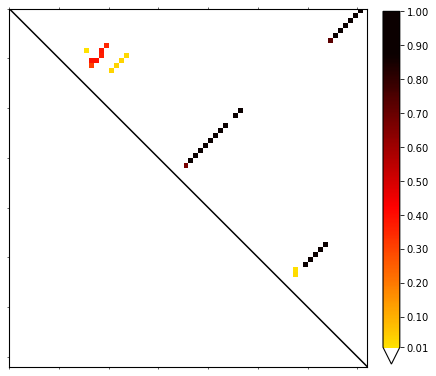

In [4]:
trna="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"

matplfold = getBPPM_plfold(trna, W=80,L=50)
matfold = getBPPM(trna)
p = plot_heat_maps(None, matplfold)
p = plot_heat_maps(None, matfold)

In [5]:
def walk_basepairs_get_stems(mat, p_thresh=0.1, inner_loop=False):
    #print("walk_basepairs_get_stems")
    bpXs, bpYs = np.where(mat > p_thresh) # Note: hopefully the returned  indices of where are sorted by x values
    #print(list(zip(bpXs, bpYs)))
    bpXs +=1
    bpYs += 1 
    if len(bpXs) == 0:
        #print ("WARNING: No basepair with prob larger than {}".format(p_thresh))
        return {}
        
    # startX: 3'end startY:5'end of the stem
    stem_startX, stem_startY = bpXs[0], bpYs[0]
    stem_endX, stem_endY = bpXs[0], bpYs[0]
    stems_dict = {} 
    stems_list = []
    for x, y in zip(bpXs, bpYs):
        
        #print ('  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY))

        #print (x,y)
        if ( abs(x-stem_endX) < 5 and abs(y-stem_endY) < 5 and
               ((~inner_loop and ( (abs(x-stem_endX) <= 1) or (abs(y-stem_endY) <= 1)))
                or 
                (inner_loop  and ( (abs(x-stem_endX) <= 3) or (abs(y-stem_endY) <= 3)))
               )
               ):
        
            
            if (abs(x-stem_endX) >= 5) or (abs(y-stem_endY) >= 5):
                print ("WARNING: bulge of size larger than 5 added at x={}, y={}! ".format(x,y))
                
            
            stem_endX = max(x, stem_endX)
            stem_startX = min(x, stem_startX)
            stem_endY = min(y, stem_endY)
            stem_startY = max (y, stem_startY)
                
        else:
            #print " new",
            #print ('new  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY))
            # Validating order of stem indices
            
            assert stem_startX <= stem_endX
            assert stem_endX < stem_endY
            assert stem_endY <= stem_startY
            
            # stem coords as key string
            k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # (stem_length, stem_span) as dict value
            stems_dict[k] = min( (stem_endX-stem_startX)+1 , (stem_startY-stem_endY)+1), stem_endY-stem_endX-1
            
            stem_startX, stem_startY = x, y
            stem_endX, stem_endY = x, y
    
    k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
    #print k, stem_endX-stem_startX , (stem_startY-stem_endY)
    assert k not in stems_dict # It should be the case always..?
    stems_dict[k] = min( (stem_endX-stem_startX+1) , (stem_startY-stem_endY+1)), stem_endY-stem_endX-1 
    
    return stems_dict


def filter_stemsd_list(sdl, max_inner_distance=10, min_stem_length=4):
    sdl_filt = list()
    for sd in sdl:
        #print sd
        sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
        #print sd_filt
        #print
        sdl_filt.append(sd_filt)
    return sdl_filt

def find_stem_in_range(stem_dict, search_range):

    keys = [k for k in stem_dict]
    centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in keys]
    loop_sizes = [int(re.split("\D+", k)[2]) -int(re.split("\D+", k)[1]) for k in keys]
    stem_in_range_arr = [search_range[0]<=c<=search_range[1] for c in centers ]
    if True in stem_in_range_arr:
        hit_loop_size_dict = {keys[i]:d for i,d in enumerate(loop_sizes) if stem_in_range_arr[i]}
        #shortest_loop_size = min(hit_loop_size_dict.values())
        #list(hit_loop_size_dict.keys())[list(hit_loop_size_dict.values()).index(shortest_loop_size)]
        return hit_loop_size_dict
    else:
        return {}



def fasta_to_df(fasta_file, use_dpps_folder=False, add_shuffle=False,add_bpmat=True, use_plfold=True, plfold_W=150, plfold_L=100,
                filter_stems=True, max_inner_stem_distance=10, min_stem_length=4, cleanup_df=False, search_range=None):
    seq_recs = list(SeqIO.parse(fasta_file, format='fasta'))
    df_fasta = pd.DataFrame(index=[r.id for r in seq_recs])

    df_fasta['sequence'] = [str(s.seq).upper().replace('T','U') for s in seq_recs] 
    do_dinuc_shuf = False

    if add_shuffle:
        if do_dinuc_shuf:
            df_fasta['sequence-shuffled'] = [dinuclShuffle(s) for s in df_fasta['sequence']]
        else:
            df_fasta['sequence-shuffled'] = [''.join(random.sample(s,len(s))) for s in df_fasta['sequence']]
    if add_bpmat:
        if use_plfold is False:
            df_fasta['bp-matrix'] = [getBPPM(s) for s in df_fasta['sequence']]
            if add_shuffle:
                df_fasta['bp-matrix-shuffled'] = [getBPPM(s) for s in df_fasta['sequence-shuffled']]
        else:
            df_fasta['bp-matrix'] = [getBPPM_plfold(s, W=plfold_W, L=plfold_L) for s in df_fasta['sequence']]
            if add_shuffle:
                df_fasta['bp-matrix-shuffled'] = [getBPPM_plfold(s, W=plfold_W, L=plfold_L) for s in df_fasta['sequence-shuffled']]
    
    stems_nofilt = [walk_basepairs_get_stems(s) for s in df_fasta['bp-matrix']]
    stems = filter_stemsd_list(stems_nofilt)
    df_fasta['stems-all'] = stems_nofilt
    df_fasta['stems-size-filtered'] = stems
    
    if search_range is not None:
        df_fasta['in-range'] = [find_stem_in_range(stem, search_range) for stem in stems]

    if cleanup_df:
        return df_fasta[[c for c in df_fasta.columns if c in ['stems-size-filtered','in-range']]]
    return df_fasta
# walk_basepairs_get_stems(bpmat,inner_loop=True)
# bpXs, bpYs = np.where(bpmat>0.5)
# zip(bpXs, bpYs, bpXs+1, bpYs+1)

fasta_to_df('./sample.fasta', cleanup_df =  True, search_range=(10,30))

,stems-size-filtered,in-range
hg19_chr1_1716777_1716877_-,"{'8-13,18-23': (6, 4)}","{'8-13,18-23': 5}"
hg19_chr1_1716798_1716898_-,"{'29-34,39-44': (6, 4), '70-73,78-81': (4, 4)}",{}
hg19_chr1_1716898_1716998_-,"{'25-41,46-63': (17, 4)}",{}
hg19_chr1_1716914_1717014_-,"{'35-38,43-48': (4, 4)}",{}
hg19_chr1_1717265_1717365_-,"{'62-65,75-78': (4, 9), '70-73,79-82': (4, 5)}",{}
hg19_chr1_1717347_1717447_-,"{'3-6,15-18': (4, 8), '39-44,53-59': (6, 8), '...","{'3-6,15-18': 9}"
hg19_chr1_1717388_1717488_-,"{'1-5,10-14': (5, 4), '31-34,44-47': (4, 9), '...",{}
hg19_chr1_1717800_1717900_-,"{'1-4,12-15': (4, 7), '74-83,87-99': (10, 3)}",{}
hg19_chr1_1717836_1717936_-,"{'1-4,10-15': (4, 5)}",{}
hg19_chr1_1717875_1717975_-,"{'58-61,65-68': (4, 3), '70-77,83-88': (6, 5)}",{}


In [6]:
! head ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta -n 120 > sample.fasta
! cat sample.fasta

>hg19_chr1_1716777_1716877_- GNB1-ENSG00000078369
ACAACTCTGTAGAGCTCTCTGCACCCTTACCCCTTTCCACCTTTTGTATT
TAATTTTAAAGTCAGTGTACTGCAAGGAAGCTGGATGCAAGATAGATACT
>hg19_chr1_1716798_1716898_- GNB1-ENSG00000078369
CCTTCTTTCTCTTTCCGTCCAACAACTCTGTAGAGCTCTCTGCACCCTTA
CCCCTTTCCACCTTTTGTATTTAATTTTAAAGTCAGTGTACTGCAAGGAA
>hg19_chr1_1716898_1716998_- GNB1-ENSG00000078369
GTAGTGGCTTCTCCATCCTGTTTTCTGCAACATTCTATACAAAACTGTGC
TGTGACCTTGCGGTAGGCCTGGATCTGGCAAAGAGAATACAAATGAAACC
>hg19_chr1_1716914_1717014_- GNB1-ENSG00000078369
CTCCTTCATAGCAGCAGTAGTGGCTTCTCCATCCTGTTTTCTGCAACATT
CTATACAAAACTGTGCTGTGACCTTGCGGTAGGCCTGGATCTGGCAAAGA
>hg19_chr1_1717265_1717365_- GNB1-ENSG00000078369
GCGGCTCTGTCCACTTCTCGTTGCTGCTCTGTGGCACATATCGGAAGCAG
TACAGCGCGCGGCTCTACACGCTTGGGTAGCGGGATAAGTCACTGTTTTC
>hg19_chr1_1717347_1717447_- GNB1-ENSG00000078369
AAATGCTCAAAAGTGCATATGGGACTCAGTCCTTAGGTGTTCTTTTTCTT
TTAAGAAATAACCTCTTACAGTTGTAACCATTGCGGCTCTGTCCACTTCT
>hg19_chr1_1717388_1717488_- GNB1-ENSG00000078369
GCCATATTGGGTGGGTTTACTCTTAGAATCGCATGCTG

Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered].*
Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.shuffled].shuffled.*


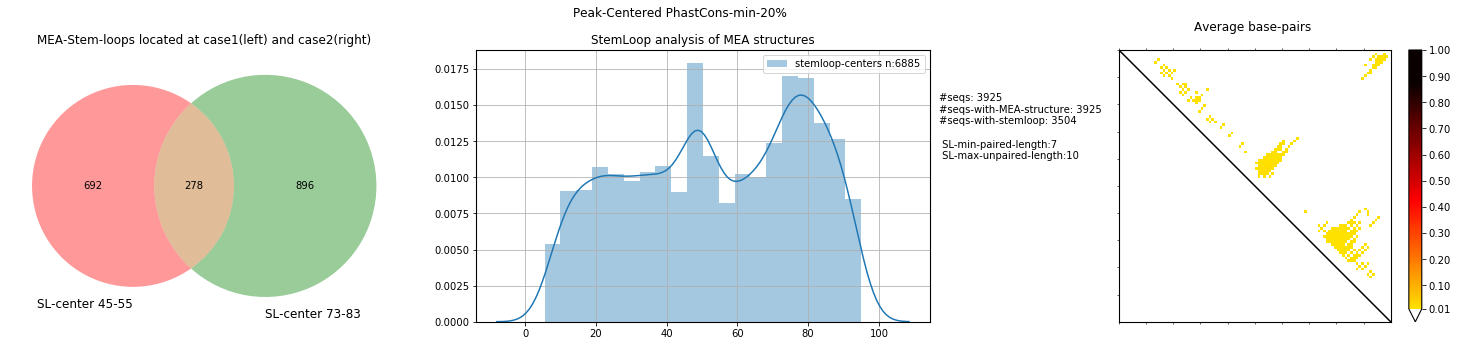

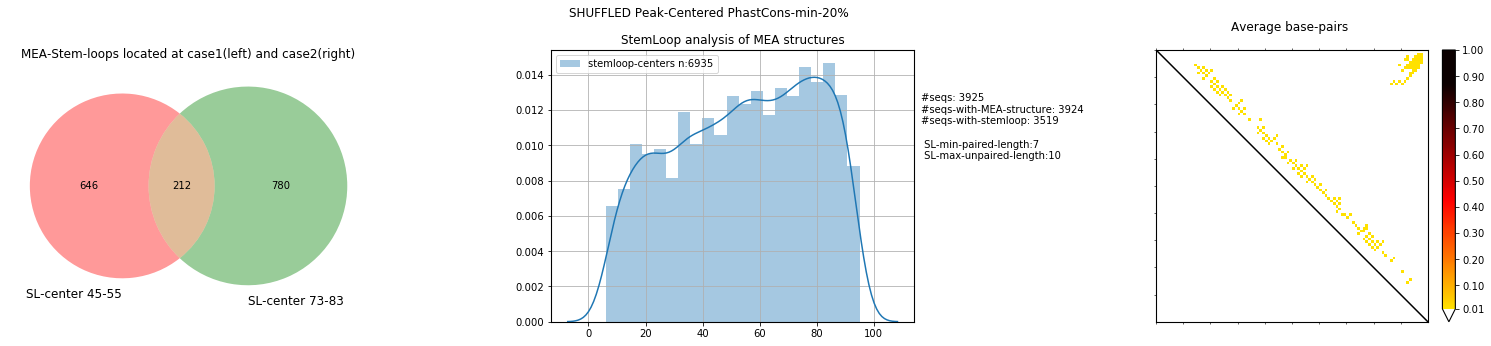

In [7]:
from matplotlib_venn import venn2#, venn3_circles
def plot_venn(stems, rangeA = (45,55), rangeB = (73,83), ax=None):
    setinA, setinB = set(), set()

    for ids, sdic in enumerate(stems):
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in sdic]
        inA = 0 < len([c for c in centers if rangeA[0]<=c<=rangeA[1]])
        inB = 0 < len([c for c in centers if rangeB[0]<=c<=rangeB[1]])
        if inA:
            setinA.add(ids)
        if inB:
            setinB.add(ids)
        
    venn2([setinA, setinB], set_labels =['SL-center {}-{}'.format(*rangeA),'SL-center {}-{}'.format(*rangeB)],ax=ax)
    

def plot_stems_loc(stemdl_nonfilt, title='',filt=False, max_inner_distance=10, min_stem_length=7, venn=True,rangeA = (45,55), rangeB = (73,83),axes=None):
    if filt is True:
        stemdl = filter_stemsd_list(stemdl_nonfilt)
    else:
        stemdl = stemdl_nonfilt
    if axes is None:
        fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    #starts = [ int(re.split("\D+", k)[1]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(starts, ax=ax,label='starts')
    #ends = [ int(re.split("\D+", k)[2]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(ends,ax=ax,label='ends')
    
    centers = [ int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for sd in stemdl for k in sd  if len(sd)>0 ]
    #print centers
    sns.distplot(centers,ax=axes[1],label='stemloop-centers n:{}'.format(len(centers)))
    axes[1].legend()
    axes[1].annotate(#xytext = (0.4, 0.4),
                     xy=(1.02,.6),
                     xycoords='axes fraction',
                     s=             '#seqs: {}\n#seqs-with-MEA-structure: {}\n#seqs-with-stemloop: {}\n\n SL-min-paired-length:{}\n SL-max-unpaired-length:{}   '.format(len(stemdl_nonfilt), 
                                                                                  len([sd for sd in stemdl_nonfilt if len(sd)>0]),
                                                                                  len([sd for sd in stemdl if len(sd)>0]),
                                                                                  min_stem_length,max_inner_distance
                                                                                                                          ),
#             horizontalalignment='left',
                )
    
    axes[1].set_title('StemLoop analysis of MEA structures')
    if venn is True:
        plot_venn(stemdl,ax=axes[0],rangeA=rangeA, rangeB=rangeB)
        axes[0].set_title('MEA-Stem-loops located at case1(left) and case2(right)')

#     fig.suptitle(title + '\nStemLoop analysis of MEA structures\n'                , y=1.0)
    
def analyze_df(df, filename,title='',average=True, walk_stems=True, venn=True, filt=False,rangeA = (45,55), rangeB = (73,83)):
    
    axes=None
    if average:
        fig, axes= plt.subplots(ncols=3,figsize=(26,5))
        fig.suptitle(title , y=1.0)
        fig.subplots_adjust(wspace=.1)
        
        figshuf, axesshuf= plt.subplots(ncols=3,figsize=(26,5))
        figshuf.suptitle('SHUFFLED ' + title , y=1.0)
        figshuf.subplots_adjust(wspace=.5)
        
        average_bpmat = np.average(df['bp-matrix'])
        average_bpmat_shuff = np.average(df['bp-matrix-shuffled'])
        
        fig_file =  filename.replace('fasta','fa').replace('.fa','')
        fig_file_shuff = filename.replace('fasta','fa').replace('.fa','.shuffled')
        #fig= plt.figure(figsize=(12,5))#subplots(ncols=2,figsize=(12,5))

        my_heatmap(average_bpmat, fig,axes[2], 
                   inverse=True, interactive=False, gene_loc=None,title='Average base-pairs ')
        my_heatmap( average_bpmat_shuff,figshuf,axesshuf[2],
                   inverse=True, interactive=False, gene_loc=None, title='Average base-pairs ')
        
    if walk_stems:
        stems = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
        plot_stems_loc(stems,venn=venn, filt=filt,title=title,axes=axes[:],rangeA=rangeA, rangeB=rangeB)
        #plt.show()
        stems_shuf = [walk_basepairs_get_stems(s) for s in df['bp-matrix-shuffled']]
        plot_stems_loc(stems_shuf,venn=venn,filt=filt,title= title + ' SHUFFLED',axes=axesshuf[:], rangeA=rangeA, rangeB=rangeB)
        #plt.show()
    fig.savefig(fig_file+'.pdf',bbox_inches='tight')
    figshuf.savefig(fig_file_shuff+'.pdf',bbox_inches='tight')
    fig.savefig(fig_file+'.svg',bbox_inches='tight')
    figshuf.savefig(fig_file_shuff+'.svg',bbox_inches='tight')
    
    print ("Fig saved to " , fig_file+".*")
    print ("Fig saved to " , fig_file_shuff+".*")
    

fa_peakcentered = '../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta' #'./sample.fasta'
mydf_peakcentered = fasta_to_df(fa_peakcentered, add_shuffle=True)
analyze_df(mydf_peakcentered,fa_peakcentered,title='Peak-Centered PhastCons-min-20%',average=True,walk_stems=True,filt=True,rangeA = (45,55), rangeB = (73,83))